In [2]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import keras_losses as kl
import metrics as mets
import predictions_preprocessing as pp
import sklearn.externals.joblib

In [3]:
#get i/o data
z_f = '../data/zData_090219.txt' #redshift file
p_f = '../data/PT_v4_test.txt'#cosmo param file
s_f = '../data/T21data_v4_test.txt'#signal file
x, y = pp.get_data(z_f, p_f, s_f)

In [4]:
#scale inputs/output of model using same transformation used in training. select which params to use as input
x_scale_f = '../saved_models/scalers/9_params_21_2_x_scaler.pkl'
y_scale_f = '../saved_models/scalers/9_params_21_2_y_scaler.pkl'
x, y, _, y_scaler = pp.scale_data(x, y, x_scale_f, y_scale_f)

In [6]:
#needed for custom metric
#these are taken from y_scaler
mean = y_scaler.mean_[0]
var = y_scaler.var_[0]

In [5]:
#load 'best' keras model
nn_name = '8_params_phys_mlp_16_128_001'
twenty_one_err_met = kl.twenty_one_cm_rmse_higher_order(mean, var) #rmse over data not ts
model = tf.keras.models.load_model("../saved_models/keras/" + nn_name + ".h5", custom_objects={'twenty_one_cm_rmse': twenty_one_err_met, 'BatchNormalizationV1': tf.keras.layers.BatchNormalization, 'GlorotUniform': tf.keras.initializers.glorot_uniform()})

In [6]:
#predict on your data
y_pred = model.predict(x)

rmse(y_true, y_pred) / max(|y_true|) for each curve, mean
0.051656365795453546
rmse(y_true, y_pred) / max(|y_true|) for each curve, median
0.03799868955454876
rmse(y_true, y_pred) / max(|y_true|) for each curve, min
0.01052635927323358
rmse(y_true, y_pred) / max(|y_true|) for each curve, max
0.5159331940123323


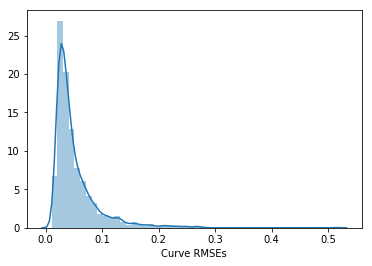

In [7]:
#histogram of errors as defined in anastasia's paper
rmse_ts = mets.twenty_one_cm_rmse_ts_higher_order(mean, var, n_z)(y, y_pred)
print 'rmse(y_true, y_pred) / max(|y_true|) for each curve, mean'
print np.mean(rmse_ts)
print 'rmse(y_true, y_pred) / max(|y_true|) for each curve, median'
print np.median(rmse_ts)
print "rmse(y_true, y_pred) / max(|y_true|) for each curve, min"
print np.min(rmse_ts)
print "rmse(y_true, y_pred) / max(|y_true|) for each curve, max"
print np.max(rmse_ts)
plt.figure('test rmse(y_true, y_pred) / max(|y_true|) for each curve, histogram, ' + nn_name)
plt.xlabel('Curve RMSEs')
sns.distplot(rmse_ts)

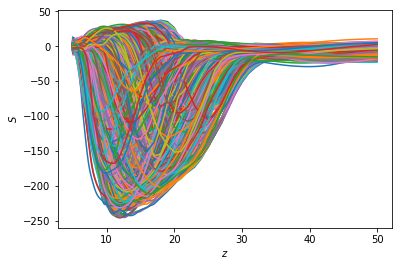

In [8]:
#reshape back to original form S_z({p}), and inverse transform back to physical values
y_z_pred = y_scaler.inverse_transform(y_pred).reshape(-1,n_z)
plt.figure('signals')
plt.xlabel(r"$z$")
plt.ylabel(r"$S$")
for i in range(y_z_pred.shape[0]):
    plt.plot(z, y_z_pred[i,:])